In [1]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

import matplotlib.pyplot as plt

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
group = [
    [34, 40, 42, 41, 4, 10, 11, 12],
    [35, 6, 48, 27, 57, 8, 25, 56, 26, 55, 47, 13, 53, 18, 7, 17, 46],
    [31, 33, 9, 3, 1, 32],
    [29, 38, 43, 58, 15, 22, 39, 54, 23, 44, 45, 37, 52, 2, 14],
    [21, 19, 50, 49, 20, 51, 30, 36, 28, 59, 5, 60, 16, 24]
]

group_selection = True
choose_group = 4

Save_Switch = False

In [3]:
data_path = "./data/train.csv"

data = pd.read_csv(data_path, parse_dates = ["date_time"])

data["time_idx"] = 0
data["month"] = 0
data["Week"] = 0
data["24Hour"] = 0
data["holiday"] = 0
data["Weekend"] = 0

data.loc[data["date_time"].dt.month == 6, 'month'] = 0
data.loc[data["date_time"].dt.month == 7, 'month'] = 30
data.loc[data["date_time"].dt.month == 8, 'month'] = 61

data.loc[(data["date_time"].dt.month == 8) & (data["date_time"].dt.day == 17) , 'holiday'] = 1

data["time_idx"] = data["date_time"].dt.hour + data["date_time"].dt.day * (24) + data["month"] * 24
data["time_idx"] = data["time_idx"] - min(data["time_idx"])

data["Week"] = (data["date_time"].dt.day + data["month"]) % 7
data["24Hour"] = data["date_time"].dt.hour

data.loc[data["Week"] == 6, 'Weekend'] = 1
data.loc[data["Week"] == 0, 'Weekend'] = 1

data = data.drop("month",axis='columns')

data.rename(columns = {'전력사용량(kWh)' : 'kWH', '기온(°C)' : 'C', '풍속(m/s)' : 'm/s', '습도(%)' : 'wet', '강수량(mm)' : 'mm','일조(hr)' : 'hr', '비전기냉방설비운영' : "non_electric_aircondition", "태양광보유" : "sunlight"}, inplace = True)

data = data.astype({'non_electric_aircondition' : int, 'sunlight' : int})
data['num'] = data['num'].apply(str)
data['Week'] = data['Week'].apply(str)
data['24Hour'] = data['24Hour'].apply(str)
data['holiday'] = data['holiday'].apply(str)
data['Weekend'] = data['Weekend'].apply(str)

data_bag = [data.loc[data["num"] == str(i+1)] for i in range(60)]

if Save_Switch:
    for i in range(len(data_bag)):
        data_bag[i].to_csv(f"Refined_Data/Seperated_Data/{i+1}.csv", mode='w')

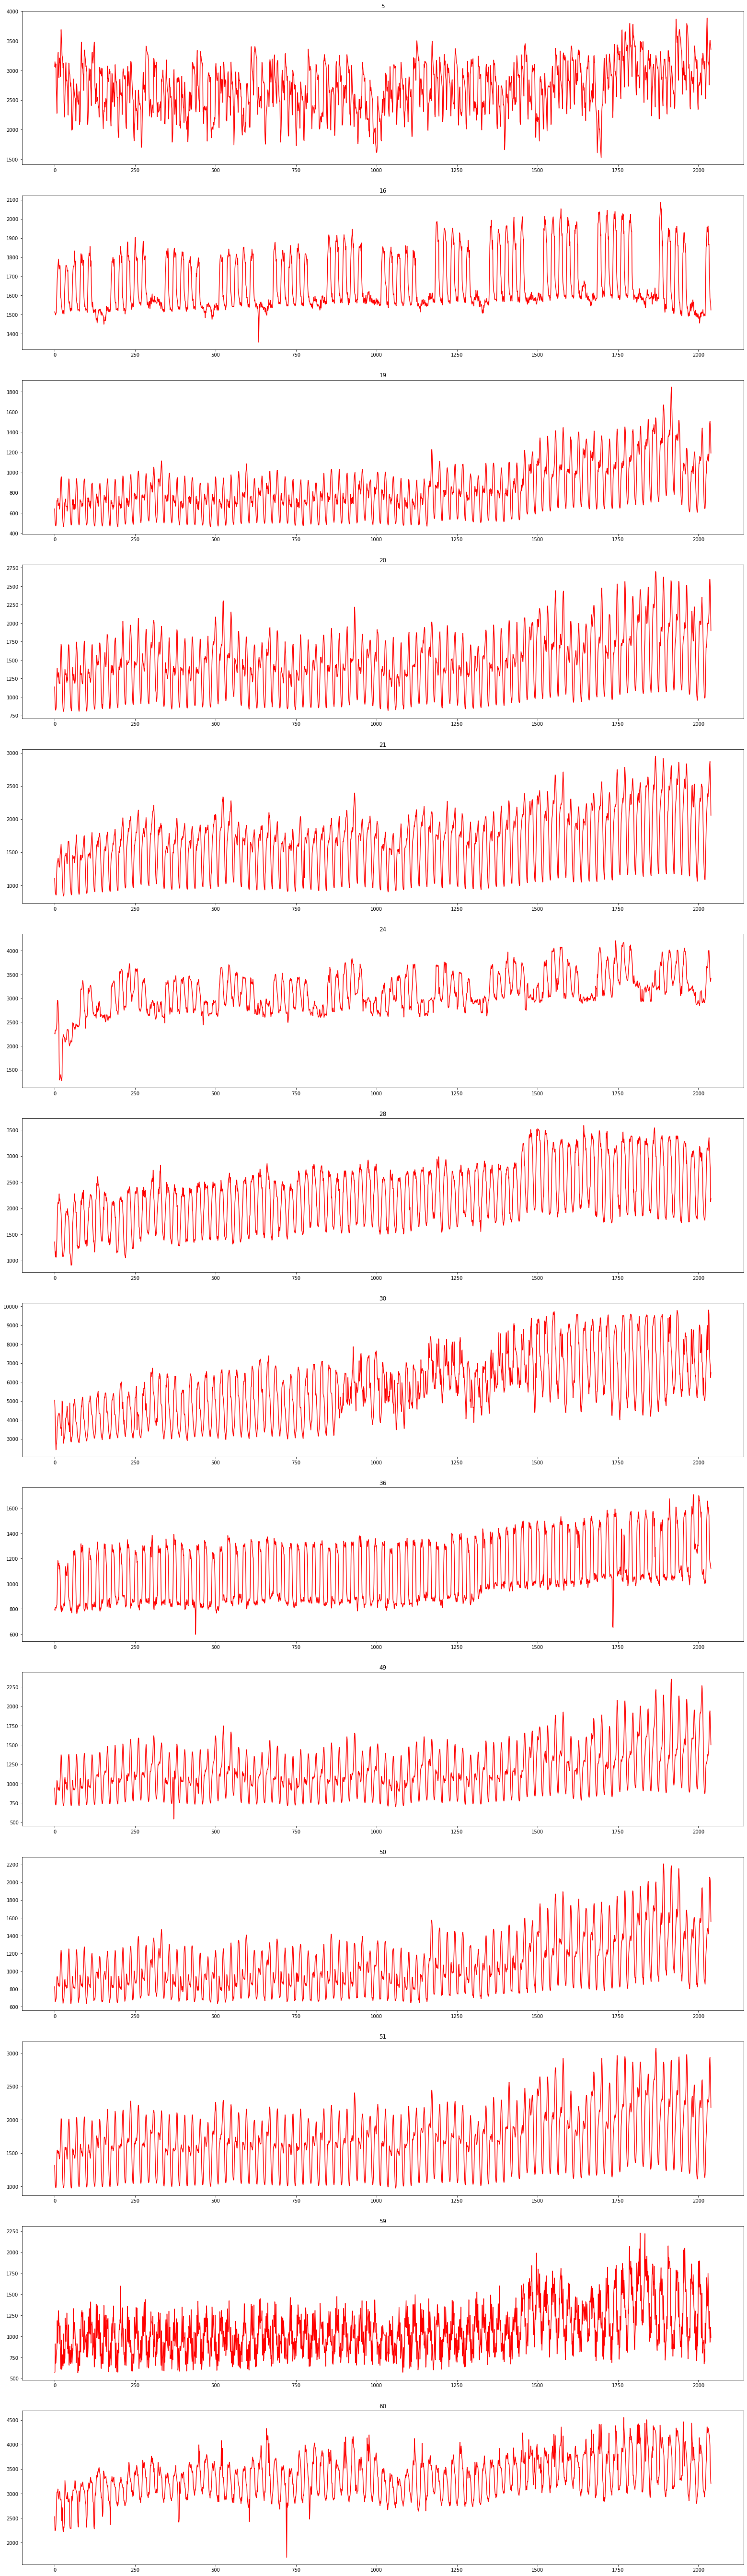

In [4]:
max_num = len(group[choose_group]) if group_selection else 60

plt.rcParams["figure.figsize"] = (27, 7 * max_num)
fig = plt.figure()

graphs = [fig.add_subplot(max_num, 1, i+1) for i in range(max_num)]
j = 0

for i in range(len(data_bag)):
    if group_selection and i+1 not in group[choose_group]:
        continue

    now_plot_data = data_bag[i]["kWH"].tolist()
    graphs[j].set_title(f"{i+1}")
    graphs[j].plot(now_plot_data, color='red')
    j+=1

plt.show()